# Predicting swings and misses

The least productive result for a batter in an at bat is a swing and miss. Here, I'll try to predict whether a pitch results in a swing and miss for a given batter.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Approach

I'll divide pitch results into two cateogories: swinging strike or other. I'll begin by investigating various features that intuition suggests could effect when there's not only a swing, but also a miss. I'll then use a random forest classifier to predict the outcome of the pitch, as I will be working with both categorical and quantitative features.

I'll be looking at predicting swinging strikes based on batters. In other words, I'll look to create a model for each individual hitter.

## Loading data

I'll start by loading in pitch information from where a given batter is hitting. For these tests, I'll start with Jack Cust, who was known for two things: hitting home runs and striking out.

In [2]:
# specify database name
dbname = "../../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [3]:
# import classes
sys.path.append('../../src')
from Player import Player

# create player object
jc = Player("Jack Cust", db)

# grab pitches
jc_pitches = jc.pitches_against(clean=1).reset_index(drop=True)
# grab events
jc_events = jc.hit_events()
# grab games
jc_games = jc.hit_games()

## Data exploration

I'll first look at the distribution of pitch outcomes.

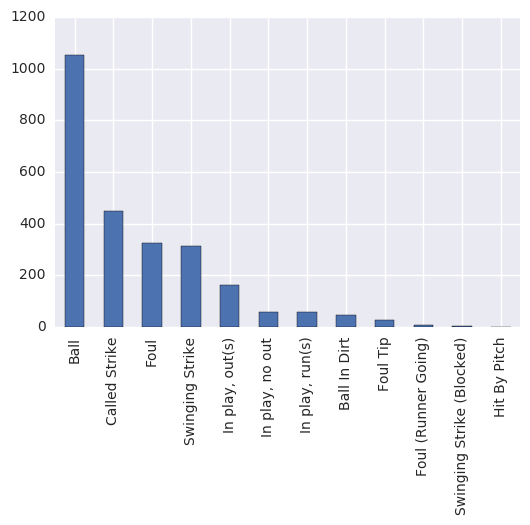

In [4]:
# pitch outcome distribution
plt.subplots()
jc_pitches['description'].value_counts().plot.bar()
plt.show()

Swinging stike is the fourth most common pitch outcome for Cust.

In [5]:
# swing strike percentage
swing_strike = np.sum(jc_pitches['description'].value_counts()[['Swinging Strike', 'Swinging Strike (Blocked)']])
print("Percentage of swinging strikes: ", swing_strike/len(jc_pitches))

Percentage of swinging strikes:  0.126450580232


Cust swings and misses on 12% of the pitches he sees. This will be related to the base error rate. By guessing that there is not a swing and miss on all pitches, the model would be correct 88% of the time. This is the accuracy I would like to surpass.

I'll look at whether there are any potential features that could help predict a swing and a miss for Cust. The most obvious features are related to the pitch location and trajectory.

### Pitch locations

I'll plot the pitch locations for swings and misses, called strikes, foul balls, balls, hits, and hits for outs.

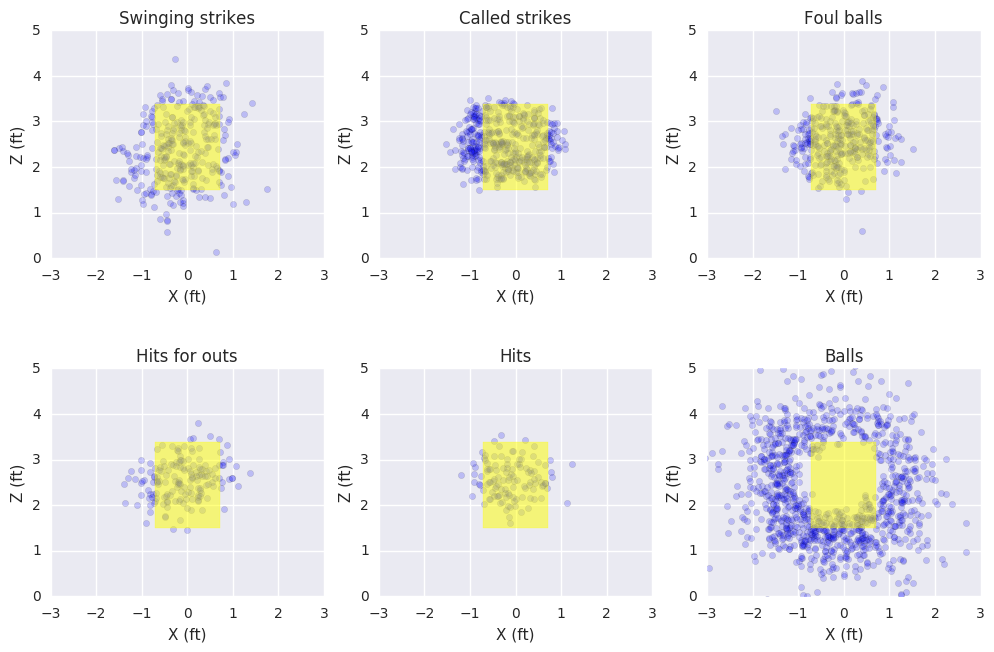

In [6]:
# swinging/called strikes and foul balls
jc_swing_strike = jc_pitches[jc_pitches['description'].str.contains("Swinging Strike")]
jc_called_strike = jc_pitches[jc_pitches['description'].str.contains("Called Strike")]
jc_foul = jc_pitches[jc_pitches['description'].str.contains("Foul")]
jc_outs = jc_pitches[jc_pitches['description'].str.contains("In play, out")]
jc_hits1 = jc_pitches[jc_pitches['description'].str.contains("In play, no")]
jc_hits2 = jc_pitches[jc_pitches['description'].str.contains("In play, run")]
jc_hits = pd.concat([jc_hits1, jc_hits2])
jc_balls = jc_pitches[jc_pitches['description']=='Ball']

# strike zone dimensions
sz_top = jc_swing_strike['sz_top'].iloc[0]
sz_bot = jc_swing_strike['sz_bot'].iloc[0]
sz_left = -8.5/12
sz_right = 8.5/12

# create lists for plots
infox = [jc_swing_strike['px'], jc_called_strike['px'], jc_foul['px'],
         jc_outs['px'], jc_hits['px'], jc_balls['px']]
infoz = [jc_swing_strike['pz'], jc_called_strike['pz'], jc_foul['pz'],
         jc_outs['pz'], jc_hits['pz'], jc_balls['pz']]
titles = ['Swinging strikes', 'Called strikes', 'Foul balls',
          'Hits for outs', 'Hits', 'Balls']

# plot where pitches cross the plate
ncol = 2
nrow = 3
fig, ax = plt.subplots(ncol, nrow, figsize=(12, 8))

for ii, ax in enumerate(fig.axes):
    ax.scatter(infox[ii],
               infoz[ii],
               alpha=0.2)
    ax.add_patch(plt.Rectangle((sz_left, sz_bot),
                               sz_right-sz_left,
                               sz_top-sz_bot,
                               color='yellow',
                               alpha=0.5),)
    ax.set_title(titles[ii])
    ax.set_xlabel('X (ft)')
    ax.set_ylabel('Z (ft)')
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 5)
    ax.set_aspect('equal')

plt.show()

There are a number of remarks from these plots. With respect to swinging strikes, Cust swings and misses at pitches primarily on the outer half of the plate (he bats left-handed), particularly away. Some other observations are that Cust takes a lot of pitches down and in (regardless of whether they are balls or strikes), and that there are a lot of strikes called off the outside of the plate (beyond the supposed strike zone).

I'll look more closely at how swinging strikes are distributed through the strike zone though a density and histogram plot.

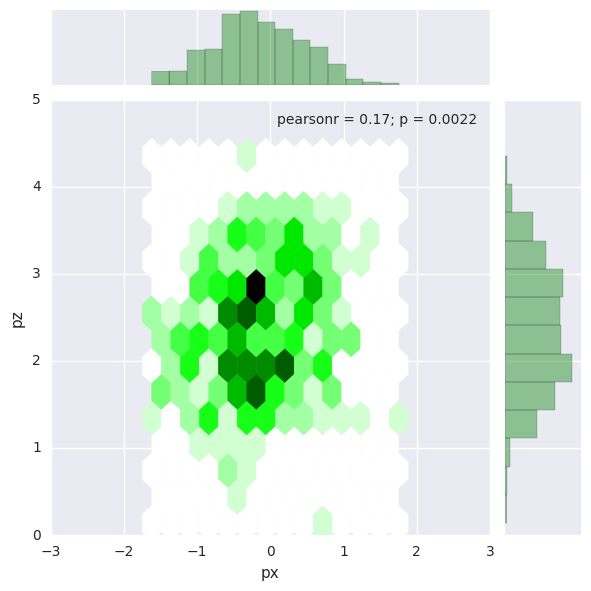

In [7]:
# plot density and histogram plot
sns.jointplot(jc_swing_strike['px'],
              jc_swing_strike['pz'],
              color="green",
              kind="hex",
              xlim=[-3, 3],
              ylim=[0, 5])
plt.show()

This further suggests that Cust swings and misses on a lot of pitches on the outside half of the plate.

It could also be interesting to look at histograms of swinging strikes and swings with other outcomes across the strike zone.

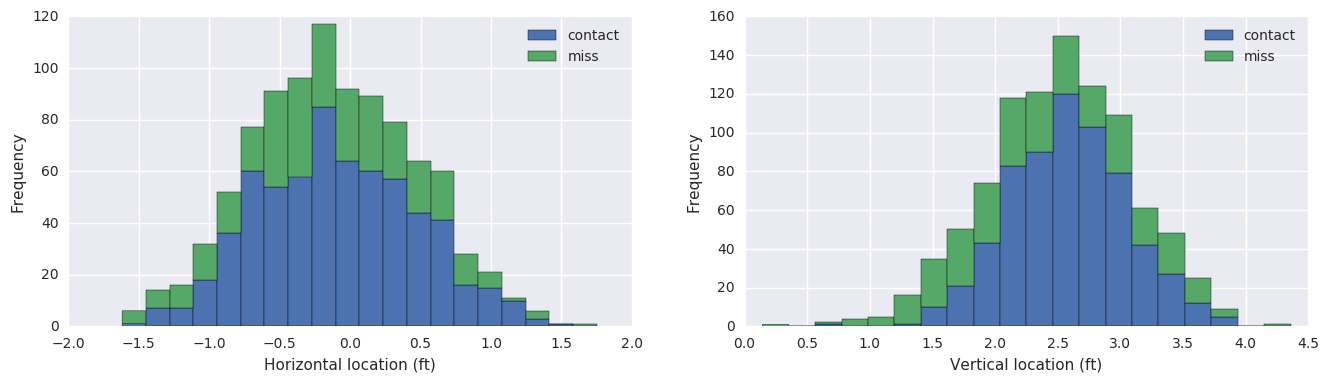

In [8]:
# create contact rate
jc_contact = pd.concat([jc_outs[['px', 'pz']],
                      jc_hits[['px', 'pz']],
                      jc_foul[['px', 'pz']]],
                      axis=0)

# bin parameters
nbins = 20

# stacked histograms
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# strike zone location
pd.concat([jc_contact['px'],
          jc_swing_strike['px']],
          axis=1).plot.hist(stacked=True,
                            ax=ax[0],
                            bins=nbins)
ax[0].set_xlabel('Horizontal location (ft)')
ax[0].legend(['contact', 'miss'])

pd.concat([jc_contact['pz'],
          jc_swing_strike['pz']],
          axis=1).plot.hist(stacked=True,
                            ax=ax[1],
                            bins=nbins)
ax[1].set_xlabel('Vertical location (ft)')
ax[1].legend(['contact', 'miss'])

plt.show()

The plot on the left further suggests that when Cust swings, he misses more when the pitch is on the outside of the plate. The plot on the right suggests that Cust swings and misses more on pitches down in the zone than up in the zone.

### Pitch trajectories

Now I'll look at the trajectory information for 